# Computer Vision CSCI-GA.2272-001 Assignment 1

## Introduction

This assignment is an introduction to using PyTorch for training simple neural net models. Two different datasets will be used: 
- MNIST digits [handwritten digits]
- CIFAR-10 [32x32 resolution color images of 10 object classes].

## Requirements

You should perform this assignment in PyTorch, modify this ipython notebook

To install PyTorch, follow instructions at http://pytorch.org/

Please submit your assignment by uploading this iPython notebook to NYU classes.

## Warmup [10%]

It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand.

MNIST is a dataset of 70,000 grayscale hand-written digits (0 through 9).
60,000 of these are training images. 10,000 are a held out test set. 

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes
(airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). 
The train/test split is 50k/10k.

Use `matplotlib` and ipython notebook's visualization capabilities to display some of these images.
[See this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for hints on how to achieve this.

** Relevant Cell: "Data Loading" **


In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.autograd import Variable

# Additional packages other than default notebook.
from matplotlib import pyplot as plt
import numpy as np
from torchviz import make_dot

# options
dataset = 'mnist' # options: 'mnist' | 'cifar10'
batch_size = 64   # input batch size for training
epochs = 10      # number of epochs to train
lr = 0.01        # learning rate

# Data Loading
# Warning: this cell might take some time when you run it for the first time, 
#          because it will download the datasets from the internet
if dataset == 'mnist':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

elif dataset == 'cifar10':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.CIFAR10(root='.', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


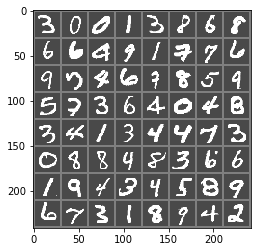

In [2]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(utils.make_grid(images))


## Training a Single Layer Network on MNIST [20%]

Start by running the training on MNIST.
By default if you run this notebook successfully, it will train on MNIST.

This will initialize a single layer model train it on the 50,000 MNIST training images for 10 epochs (passes through the training data). 

The loss function [cross_entropy](http://pytorch.org/docs/master/nn.html?highlight=cross_entropy#torch.nn.functional.cross_entropy) computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given `target`.

The default values for the learning rate, batch size and number of epochs are given in the "options" cell of this notebook. 
Unless otherwise specified, use the default values throughout this assignment. 

Note the decrease in training loss and corresponding decrease in validation errors.

Paste the output into your report.
(a): Add code to plot out the network weights as images (one for each output, of size 28 by 28) after the last epoch. Grab a screenshot of the figure and include it in your report. (Hint threads: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) [#2](https://github.com/pytorch/vision#utils) )

(b): Reduce the number of training examples to just 50. [Hint: limit the iterator in the `train` function]. 
Paste the output into your report and explain what is happening to the model.

In [3]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

def train(network, epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

def test(network, last_epoch=False):
    with torch.no_grad():
        network.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = Variable(data, volatile=True), Variable(target)
            output = network(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').data.item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))


In [ ]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test()

linear.weight tensor([[ 1.1831e-02,  1.2162e-02,  2.6806e-02,  ..., -2.7807e-02,
          2.3772e-02, -8.9213e-03],
        [-7.1571e-03, -1.7046e-02,  1.5605e-02,  ...,  1.9322e-02,
          8.2628e-03,  9.5532e-03],
        [-1.6292e-02, -8.2294e-04, -4.5438e-02,  ...,  1.1936e-02,
         -4.1764e-02, -4.0247e-02],
        ...,
        [-3.5425e-02, -8.3602e-05,  1.8134e-02,  ...,  1.5945e-02,
          3.8415e-03,  2.2798e-02],
        [-7.5982e-03, -1.9207e-02,  1.3761e-02,  ..., -2.2034e-02,
          3.5478e-02,  3.3602e-02],
        [-2.4144e-02,  1.0248e-03, -1.0617e-02,  ...,  3.8033e-02,
          3.8836e-02,  2.9389e-02]])


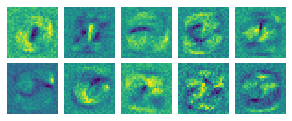

linear.bias tensor([-0.0393,  0.0048,  0.0514,  0.0287, -0.0377,  0.0230,  0.0221, -0.0223,
        -0.0370, -0.0270])


In [97]:
for name, weight in network.state_dict().items():
    print(name, weight)
    if name=='linear.weight':
        num_cols = 5
        num_kernels = weight.shape[0]
        num_rows = 1 + num_kernels // num_cols
        fig = plt.figure(figsize=(num_cols,num_rows))
        for i in range(weight.shape[0]):
            ax1 = fig.add_subplot(num_rows,num_cols,i+1)
            image_pixels = weight.tolist()[i]
            image = np.reshape(image_pixels, (-1, 28))
            ax1.imshow(image)
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.show()
        # Wow!

In [ ]:
def train(network, epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
                
network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

for epoch in range(1, 10 + 1):
    train(network, epoch)
    test(network)

## Training a Multi-Layer Network on MNIST [20%]

- Add an extra layer to the network with 1000 hidden units and a `tanh` non-linearity. [Hint: modify the `Net` class]. Train the model for 10 epochs and save the output into your report.
-  Now set the learning rate to 10 and observe what happens during training. Save the output in your report and give a brief explanation


In [ ]:
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        
        self.layer1 = nn.Linear(num_inputs, 1000)
        self.layer2 = nn.Linear(1000, num_outputs)
        self.activation = nn.Tanh()
    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        first = self.layer1(input)
        first_activation = self.activation(first)
        second = self.layer2(first_activation)
        second_activation = self.activation(second)
        output = self.activation(second_activation)
        
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

for epoch in range(1, 10 + 1):
    train(network, epoch)
    test(network)

In [6]:
lr = 10.0

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

for epoch in range(1, epochs + 1):
    train(network, epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.333347
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.472910
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.375655
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.326607
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.497256
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.507986
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.284566
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.440528
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.248913
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.313537


TypeError: test() missing 1 required positional argument: 'network'


## Training a Convolutional Network on CIFAR [50%]

To change over to the CIFAR-10 dataset, change the `options` cell's `dataset` variable to `'cifar10'`.

- Create a convolutional network with the following architecture:
  - Convolution with 5 by 5 filters, 16 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Convolution with 5 by 5 filters, 128 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

Train it for 20 epochs on the CIFAR-10 training set and copy the output
into your report, along with a image of the first layer filters.

Hints: [Follow the first PyTorch tutorial](http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py) or look at the [MNIST example](https://github.com/pytorch/examples/tree/master/mnist)

- Give a breakdown of the parameters within the above model, and the overall number.

In [ ]:
import torch.nn.functional as F

# options
dataset = 'cifar10' # options: 'mnist' | 'cifar10'
lr = 0.01        # learning rate

if dataset == 'mnist':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

elif dataset == 'cifar10':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.CIFAR10(root='.', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

class CNN(torch.nn.Module):
    
    
    def __init__(self):
        super(CNN, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 128, 5)
        self.layerA = nn.Linear(3200, 64) # Units discovered using flatten()
        self.layerB = nn.Linear(64, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.tanh(self.conv1(x)), 2)
        x = F.max_pool2d(F.tanh(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.tanh(self.layerA(x))
        x = self.layerB(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = CNN()
lr = 0.01
optimizer = optim.SGD(net.parameters(), lr=lr)
epochs = 20

for epoch in range(1, epochs + 1):
    train(net, epoch)
    test(net)

In [50]:
from PIL import Image

for name, layer in net.state_dict().items():
    print(name)
    if name=='conv1.weight':
        filter_grid = []
        for ind, filter in enumerate(list(layer)):
            print(f"filter {ind}")
            pixel_line_r = []
            pixel_line_g = []
            pixel_line_b = []
            for color, channel in enumerate(filter):
                for row in list(channel):
                    for pixel in row:
                        if color == 0:
                            pixel_line_r.append(int(float(pixel)*128+128))
                        if color == 1:
                            pixel_line_g.append(int(float(pixel)*128+128))
                        if color == 2:
                            pixel_line_b.append(int(float(pixel)*128+128))
            pixel_line = list(zip(pixel_line_r, pixel_line_g, pixel_line_b))
            print(pixel_line)
            im = Image.new('RGB', (5,5))
            im.putdata(pixel_line)
            filter_grid.append(im)
        for filter in filter_grid:
            
#             im.show()

conv1.weight
filter 0
[(131, 119, 121), (137, 142, 143), (151, 145, 160), (156, 154, 152), (131, 146, 134), (127, 125, 151), (145, 150, 150), (141, 131, 155), (136, 131, 152), (128, 136, 139), (119, 140, 139), (132, 125, 124), (147, 121, 128), (125, 139, 121), (141, 126, 138), (137, 122, 111), (120, 113, 104), (117, 98, 84), (106, 105, 89), (112, 101, 96), (121, 116, 114), (130, 100, 96), (119, 106, 114), (112, 126, 105), (123, 116, 113)]
filter 1
[(130, 127, 140), (116, 131, 139), (112, 120, 153), (122, 115, 126), (104, 125, 129), (124, 121, 115), (129, 122, 139), (124, 128, 153), (135, 136, 145), (119, 121, 140), (131, 106, 132), (139, 120, 141), (130, 131, 158), (145, 142, 156), (126, 130, 145), (132, 113, 118), (136, 120, 136), (142, 136, 144), (143, 122, 149), (146, 127, 143), (125, 120, 123), (148, 116, 113), (136, 110, 139), (145, 130, 122), (142, 121, 125)]
filter 2
[(143, 133, 141), (153, 124, 119), (117, 123, 119), (107, 106, 102), (137, 144, 126), (142, 144, 129), (135, 126,